# CLIMATE HOMEWORK
**by Gerard Tieng**

## Pre-work

In [1]:
# Import Data libraries
import numpy as np
import pandas as pd
import datetime as dt

#Import Plotting libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import desc, asc

# Reflect Tables into SQLAlchemy ORM

In [2]:
#Create engine and connect
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

# Define Base and reflect
Base = automap_base()
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [3]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [4]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

**Design a query to retrieve the last 12 months of precipitation data and plot the results**

In [5]:
# Calculate the date 1 year ago from the last data point in the database

enddate = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
print(enddate)

('2017-08-23',)


In [6]:
# Perform a query to retrieve the data and precipitation scores

lastyearsrain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= dt.date(2017,8,23), Measurement.date >= dt.date(2017,8,23)-dt.timedelta(days=365)).all()

In [7]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

df_rain = pd.DataFrame(lastyearsrain)\
.dropna()\
.sort_values(by= 'date', ascending= True)\
.set_index('date')

df_rain.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


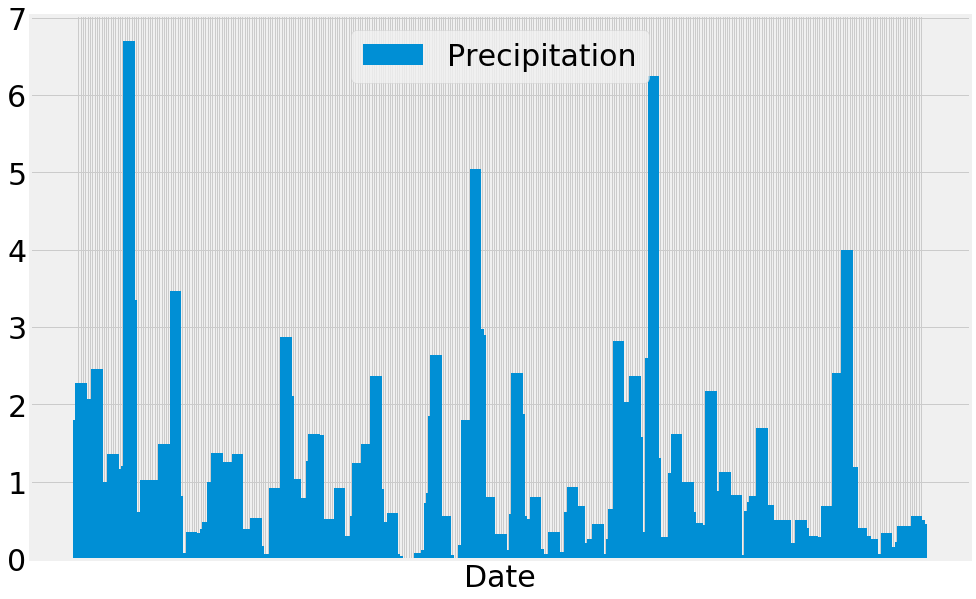

In [8]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(15,10))
plt.bar(df_rain.index, df_rain['prcp'], width=5, label='Precipitation')
plt.xlabel("Date", fontsize=30)
plt.tick_params(labelsize=30, labelbottom=False)
plt.legend(loc='upper center', fontsize=30)
plt.savefig('prcp_bar.png')
plt.show()

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df_rain.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [10]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(Station.station).all()

for stations in enumerate(station_count, 1):
    print(stations)

(1, ('USC00519397',))
(2, ('USC00513117',))
(3, ('USC00514830',))
(4, ('USC00517948',))
(5, ('USC00518838',))
(6, ('USC00519523',))
(7, ('USC00519281',))
(8, ('USC00511918',))
(9, ('USC00516128',))


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()

for i in active_station:
    print(i)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

active_hitemp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(desc(Measurement.tobs)).limit(1).all()
active_lotemp = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == 'USC00519281').order_by(asc(Measurement.tobs)).limit(1).all()
active_avgtemp = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

for hi in active_hitemp:
    print(f"Hightemp = {active_hitemp}")

for lo in active_hitemp:
    print(f"Lowtemp = {active_lotemp}")
    
print(f'Avgtemp = {active_avgtemp}')

Hightemp = [('USC00519281', 85.0)]
Lowtemp = [('USC00519281', 54.0)]
Avgtemp = [('USC00519281', 71.66378066378067)]


In [13]:
# Choose the station with the highest number of temperature observations.

most_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(desc(func.count(Measurement.tobs))).first()

for tobs in most_tobs:
    print(tobs)

USC00519281
2772


In [14]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_enddate = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(desc(Measurement.date)).first()
print(tobs_enddate)

('2017-08-18',)


In [15]:
tobs_plot = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281', Measurement.date <= dt.date(2017,8,18), Measurement.date >= dt.date(2017,8,18)-dt.timedelta(days=365)).all()

tobs_collect =[]

for stuff in tobs_plot:
    tobs_collect.append(stuff[1])

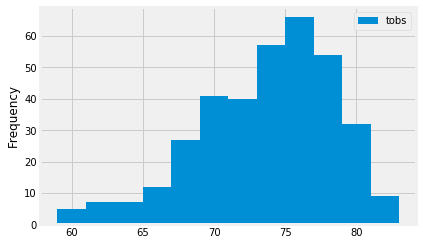

In [16]:
plt.hist(tobs_collect, bins=12, label='tobs')
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.savefig('tobs_histogram.png')
plt.show()

# Climate App

In [17]:
# Begin Flask Climate App
from flask import Flask, jsonify

app = Flask(__name__)

In [18]:
#routes

@app.route('/')
def home():
    return (f"Welcome to Gerard's Climate Site.<br/>"
            f"Here are your available routes:<br/>"
            f"<br/>"
            f'/api/v1.0/precipitation<br/>'
            f'--returns a list of precipitation values in the last 12 month period<br/>'
            f"<br/>"
            f'/api/v1.0/stations<br/>'
            f'-- returns a list of all stations collecting climate data<br/>'
            f"<br/>"
            f'/api/v1.0/tobs<br/>'
            f'-- returns a list of temperature observations in the last 12 months<br/>'
            f"<br/>"
            f'/api/v1.0/start/<font color="red">yyyymmdd</font><br/>'
            f'-- returns min, max, and average temps from the given date to end of dataset.<br/>'
            f"<br/>"
            f'/api/v1.0/startend/<font color="red">yyyymmdd</font>/<font color="blue">yyyymmdd</font><br/>'
            f'-- returns min, max, and average temps between start and end date.<br/>')
            

In [19]:
#simple returns for prcp, station, and tobs

@app.route('/api/v1.0/precipitation')
def rain():
    lastyearsrain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date <= dt.date(2017,8,23), Measurement.date >= dt.date(2017,8,23)-dt.timedelta(days=365)).all()
    session.close()
    return dict(lastyearsrain)

@app.route('/api/v1.0/stations')
def stations():
    station_count = session.query(Station.station).all()
    session.close()
    return dict(enumerate(station_count))

@app.route('/api/v1.0/tobs')
def tobs():
    temp_obs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281', Measurement.date <= "2017-08-18", Measurement.date >= "2016-08-18").all()
    session.close()
    return dict(temp_obs)


In [20]:
#routes for custom inputs

@app.route('/api/v1.0/start/<start_date>')
def onedate(start_date):

    #yyyymmdd to 'yyyy-mm-dd'
    begin = str(start_date)
    broken= [b for b in begin]
    broken.insert(4,'-')
    broken.insert(7,'-')
    glue = ""
    start_date = glue.join(broken)

    temp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).all()
    session.close()

    test = zip(['Min', 'Avg', "Max"], *temp)
    return dict([i for i in test])

@app.route('/api/v1.0/startend/<s_date>/<e_date>')
def twodates(s_date, e_date):

    #yyyymmdd to 'yyyy-mm-dd'
    twobegin = [str(s_date), str(e_date)]
    twobroken= [b for b in twobegin]
    s = [x for x in twobroken[0]]
    s.insert(4,'-')
    s.insert(7,'-')
    e = [y for y in twobroken[1]]
    e.insert(4,'-')
    e.insert(7,'-')
    glue = ""
    ss_date = glue.join(s)
    ee_date = glue.join(e)
    
    twotemp = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= ss_date, Measurement.date <= ee_date, ).all()
    session.close()

    twotest = zip(['Min', 'Avg', "Max"], *twotemp)
    return dict([j for j in twotest])

# Run App
#if __name__ == "__main__":
    #app.run(debug=True)

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

#example: valentine's day

twodates(20170214, 20170221)

{'Min': 65.0, 'Avg': 71.8936170212766, 'Max': 79.0}

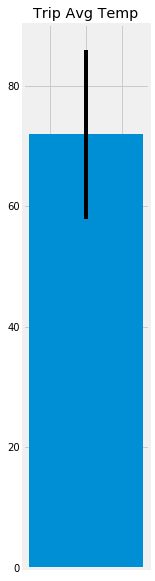

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2,10))
plt.bar(1, 71.8936170212766)
plt.title('Trip Avg Temp')
plt.errorbar(1, 71.8936170212766, yerr=(79-65), color='k')
plt.tick_params(labelbottom=False)
plt.savefig('trip_avg_temp.png')
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

tripdata_joined = session.query\
(Measurement.prcp, Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
.filter(Measurement.station == Station.station)\
.group_by(Measurement.station)\
.order_by(desc(Measurement.prcp))

In [26]:
for tsd in tripdata_joined:
    print(tsd)

(0.28, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(0.21, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(0.15, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(0.15, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(0.14, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(0.08, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(0.05, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(0.01, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
